# General data reader for AQUA 
## Units, coordinates, variable name fixer

The reader includes a simple 'data fixer', that has the capability to edit the metadata of the input datasets fixing variable or coordinate names and performing unit conversions.

In [13]:
from aqua import Reader

Let's load some MSWEP data. We first instantiate a `Reader` object specifying the type of data which we want to read from the catalogue. Then the actual data are read with the `retrieve` method. The `fix=False` for now prevents it from attempting to add unit fixes and other fixes. 

In [14]:
reader = Reader(model="MSWEP", exp="past", source="monthly", fix=False)
data = reader.retrieve()

In [15]:
data

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600, time: 502)
Coordinates:
  * lat            (lat) float32 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon            (lon) float32 -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * time           (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2020-11-01
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(32, 113, 450), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 24 00:58:27 2023: cdo -f nc mergetime 197902.nc 197...

These are raw MSWEP data on the original grid. Notice how for example a variable with short name `precipitation` represents accumulated precipitation.

In [16]:
data["precipitation"]

<xarray.DataArray 'precipitation' (time: 502, lat: 1800, lon: 3600)>
dask.array<open_dataset-precipitation, shape=(502, 1800, 3600), dtype=float32, chunksize=(32, 113, 450), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 179.9
  * time     (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2020-11-01
Attributes:
    units:    mm month-1

Now let's try again dropping the `fix=false` flag with a new Reader definition:

In [17]:
reader = Reader(model="MSWEP", exp="past", source="monthly")
data = reader.retrieve()

In [18]:
data

<xarray.Dataset>
Dimensions:  (time: 502, lat: 1800, lon: 3600)
Coordinates:
  * time     (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2020-11-01
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 179.9
Data variables:
    mtpr     (time, lat, lon) float32 dask.array<chunksize=(32, 105, 450), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed May 24 00:58:27 2023: cdo -f nc mergetime 197902.nc 197...

The resulting data are now adjusted using the instructions in the `config/fixes.yaml` file. 

The fixer has performed a range of services:
1) adopted a common 'coordinate data model': names of coordinates and dimensions (lon, lat etc.), coordinate units and sirection, name (and meaning) of the time dimension. This is implemented by a range of specific json files in the `config/data_models` folder. This is performed using the cf2cdm tool provided by `cfgrib`.
2) derived new variables. In particular from accumulated variables, like "tp" (in m), the equivalent mean-rate variables (like "tprate", paramid 172228; in m/s) have been derived. From "ttr" the equivalent rate "mtntrf" has been derived. The fixer can identify these derived variables just by their shortName (ECMWF and WMO eccodes tables are used).
3) The fixer uses the metpy.units module and is capable of guessing some basic conversions. In particular if a density is missing it will assume that it is the density of water and will take it into account. If there is an extra time unit it will assume that division by the timestep is needed.
4) The specific NextGEMS data on Levante are actually accumulated on a monthly basis (the accumulated value keeps increasing till the last timestep of the month and then it resets). The fixer can perform the needed derivation and convert these back to normal variables accumulated over a single saving step.


In [19]:
data.mtpr

<xarray.DataArray 'mtpr' (time: 502, lat: 1800, lon: 3600)>
dask.array<getitem, shape=(502, 1800, 3600), dtype=float32, chunksize=(32, 113, 450), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2020-11-01
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 179.9
Attributes:
    units:        kg m**-2 s**-1
    history:      \n2024-02-16 18:02:54 AQUA💧: Variable renamed mtpr by fixer...
    paramId:      235055
    long_name:    Mean total precipitation rate
    cfVarName:    mtpr
    shortName:    mtpr
    factor:       3.802570537683474e-07
    offset:       0
    src_units:    mm month-1
    units_fixed:  1

Let's convert the units of precipitation from kg m**-2 s**-1 to mm/day:

In [20]:
data['mtpr'] = data['mtpr']*86400
data.mtpr.attrs['units']='mm/day'

2024-02-16 18:02:55 :: plot_single_map :: ERROR    -> Cannot add cyclic longitude: The coordinate must be equally spaced.
2024-02-16 18:02:55 :: plot_single_map :: WARNING  -> Cyclic longitude can be set to False with the cyclic_lon kwarg


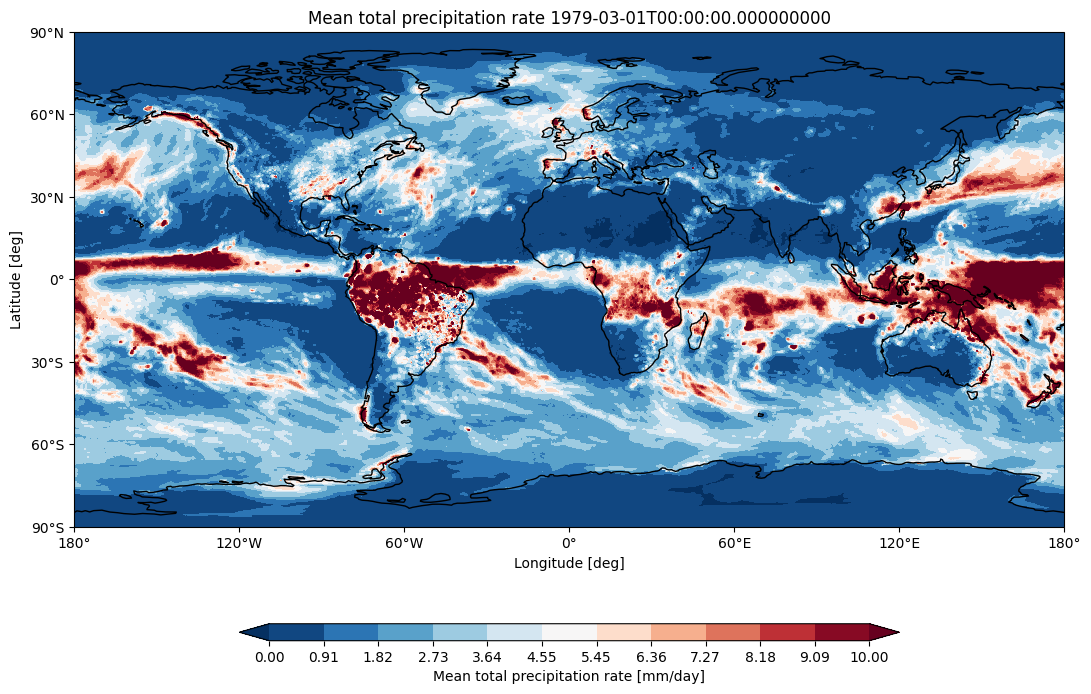

In [21]:
data.mtpr.isel(time=1).aqua.plot_single_map(vmin=0, vmax=10)

### ERA5 example

We open ERA5 data, this time asking to be a bit more 'verbose' using the `loglevel` flag.

In [22]:
from aqua import Reader, catalogue
reader = Reader(model="ERA5", exp="era5", source="monthly", fix=True, loglevel='INFO')
data = reader.retrieve()

2024-02-16 18:02:58 :: Reader :: INFO     -> Fix names in metadata is ERA5-destine-v1
2024-02-16 18:02:58 :: Reader :: INFO     -> Fix names ERA5-destine-v1 found in fixes files
2024-02-16 18:02:58 :: Reader :: INFO     -> Grid metadata is era5-r025
2024-02-16 18:02:59 :: Reader :: INFO     -> 2t: converting units K --> K
2024-02-16 18:02:59 :: Reader :: INFO     -> msl: converting units Pa --> Pa
2024-02-16 18:02:59 :: Reader :: INFO     -> mer: converting units m/day --> kg m**-2 s**-1
2024-02-16 18:02:59 :: Reader :: INFO     -> mtpr: converting units m/day --> kg m**-2 s**-1
2024-02-16 18:02:59 :: eccodes :: WARNING  -> ShortName tcc has multiple grib codes associated: ['228164', '164']
2024-02-16 18:02:59 :: eccodes :: WARNING  -> AQUA will take the first so that tcc -> 228164, please set up a correct fix if this does not look right
2024-02-16 18:02:59 :: Reader :: INFO     -> tcc: converting units (0 - 1) --> frac
2024-02-16 18:02:59 :: Reader :: INFO     -> Replacing non-metpy u

In this case, we converted the variable prate from units of m/day to kg m**-2 s**-1.

## Coordinate Data Model conversion

The fixer also converts the input 'coordinate data model' to a common standard data model. Currently by default the (CDS datamodel)[https://confluence.ecmwf.int/display/COPSRV/CDM%3A+Common+data+model+specification+-+v1.0#CDM:Commondatamodelspecificationv1.0-5.1Standardnames] is adopted in `fixes.yaml` as a destination, but other DMs can be specified creating specific json files in the `config/data_models` directory. For each dataset an 'input' datamodel can be specified or switched off (selecing `datamodel: False`)

For example, adopting the CDS datamodel makes sure that dimensions are named lon, lat, time and that they are increasing, among other things.

## Derived variables

In the 'fixer.yaml' file it is possible to specify in a flexible way renamed or derived variables. In particular one can specify that destination shortnames are grib:  then all destination attributes are recovered automatically from eccodes tables (using ecmf conventions). 
Here are some examples of what is possible (see the file for others):

- Just derive a grib variable from a source variable. Unit conversion is automatic. Example for ICON:
```
    mtpr:
          source: pr
          grib: true
```

- Define your own derived variable. Example for ERA5:
```
      mtpr:
             derived: cp+lsp
             grib: true
```

- Define your own new destination variable (ICON):
```
        mypr:
                derived: pr*86400
                 attributes:
                            units: "mm day-1"
                            long_name: My own test precipitation in mm / day
```

- Just rename and add your own attribute:
```
         msshfl:
               source: hfss
               attributes:
                    long_name: Mean surface sensible heat flux
```
Units are converted automatically as far as possible. 
Writing:
```
      mtpr:
             source: tp
             grib: true
```

will effectively convert from tp (in m) to tprate (in m/s) dividing by the accumulation timestep

As an example, let's try and load CERES-SYN daily radiation data. Since these data are not energy balanced, using the fixes.yaml file we can derive energy balanced fluxes and then derive standard ECMWF grib codes (mtntrf and mtnsrf): 

In [23]:
from aqua import Reader
reader = Reader(model="CERES", exp="syn-toa41", source="daily")
data = reader.retrieve()

In [24]:
data

<xarray.Dataset>
Dimensions:                 (time: 7670, lat: 180, lon: 360)
Coordinates:
  * time                    (time) datetime64[ns] 2001-01-01T12:00:00 ... 202...
  * lat                     (lat) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                     (lon) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    toa_sw_all_daily        (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
    toa_lw_all_daily        (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
    toa_net_all_daily       (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
    toa_lw_all_daily_eb     (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
    toa_sw_all_daily_eb     (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
    toa_solar_all_daily_eb  (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
    mtntrf                  (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
    mtnsrf                  (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
    mtnlwrf                 (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
    mtnswrf                 (time, lat, lon) float32 dask.array<chunksize=(408, 30, 60), meta=np.ndarray>
Attributes:
    title:        CERES SYN1deg Daily data
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:       
    Version:      Edition 4.1: Release Date August 22, 2019
    DOI:          10.5067/Terra+Aqua/CERES/SYN1degDay_L3.004A
    Fill_Value:   Fill Value is -999.0
    history:      \n2024-02-16 18:03:00 AQUA💧: Retrieved from CERES_syn-toa41...